# WiDS 2023

**Project Title: Brain MRI Image Classification using Convolutional Neural Networks** by Saransh Tiwari

**Description:**
This project aims to develop a Convolutional Neural Network (CNN) based solution for the classification of brain MRI images into distinct categories, including glioma, meningioma, non-tumor (notumour), and pituitary. Utilizing the PyTorch framework in Python, the CNN architecture will be designed, trained, and evaluated on a dataset comprising training and testing sets. The model's ability to accurately classify brain MRI scans will be assessed through various performance metrics, providing insights into its potential clinical applications.

We will start with first importing all the necessary libraries.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# device config for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Now, we define the training and validation dataset and resize all the images of the size 180*180 to create a uniformity.

In [3]:
IMG_SIZE = 180

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])


train_dir = r"C:\Users\hp\Downloads\Datasets\Brain MRI Images\Training"

full_dataset = ImageFolder(root=train_dir, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [10]:
full_dataset[4345]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0157, 0.0078],
          [0.0039, 0.0078, 0.0078,  ..., 0.0275, 0.0235, 0.0157],
          ...,
          [0.0118, 0.0196, 0.0235,  ..., 0.0196, 0.0196, 0.0196],
          [0.0000, 0.0039, 0.0078,  ..., 0.0157, 0.0157, 0.0157],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0157, 0.0078],
          [0.0039, 0.0078, 0.0078,  ..., 0.0275, 0.0235, 0.0157],
          ...,
          [0.0118, 0.0196, 0.0235,  ..., 0.0196, 0.0196, 0.0196],
          [0.0000, 0.0039, 0.0078,  ..., 0.0157, 0.0157, 0.0157],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0157, 0.0078],
          [0.0039, 0.0078, 0.0078,  ...,

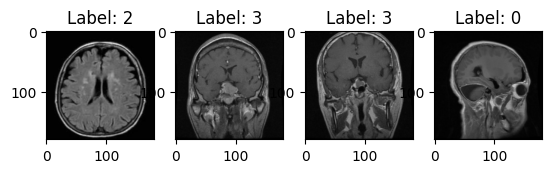

In [10]:
import matplotlib.pyplot as plt
import torchvision

# Assuming train_loader is your train dataset loader
for images, labels in train_loader:
    # Display one or two images
    num_images_to_display = 4

    for i in range(min(num_images_to_display, len(images))):
        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(torchvision.transforms.ToPILImage()(images[i]))
        plt.title(f'Label: {labels[i].item()}')

    plt.show()
    break  # Break the loop after displaying one batch


Now, it is the time to define our CNN model.

In [11]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.normalization_layer = nn.BatchNorm2d(3)  # Assuming 3 channels in your images

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.normalization_layer(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * (IMG_SIZE // 8) * (IMG_SIZE // 8))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Here, I've used three convolution layers and pooling as well. For the inner layers, ReLU activation function is used.

In [12]:
# Create an instance of the model
num_classes = 4
model = CustomCNN(num_classes=num_classes).to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
from torchsummary import summary

summary(model, input_size=(3, 180, 180), batch_size=-1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 180, 180]               6
            Conv2d-2         [-1, 16, 180, 180]             448
         MaxPool2d-3           [-1, 16, 90, 90]               0
            Conv2d-4           [-1, 32, 90, 90]           4,640
         MaxPool2d-5           [-1, 32, 45, 45]               0
            Conv2d-6           [-1, 64, 45, 45]          18,496
         MaxPool2d-7           [-1, 64, 22, 22]               0
            Linear-8                  [-1, 128]       3,965,056
            Linear-9                    [-1, 4]             516
Total params: 3,989,162
Trainable params: 3,989,162
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.37
Forward/backward pass size (MB): 9.38
Params size (MB): 15.22
Estimated Total Size (MB): 24.97
-------------------------------------

Training of the DataSet

In [31]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation after each epoch
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Accuracy: {accuracy:.4f}")

print("Finished Training")

Epoch [1/10], Validation Accuracy: 0.9204
Epoch [2/10], Validation Accuracy: 0.8906
Epoch [3/10], Validation Accuracy: 0.9081
Epoch [4/10], Validation Accuracy: 0.9239
Epoch [5/10], Validation Accuracy: 0.8810
Epoch [6/10], Validation Accuracy: 0.9230
Epoch [7/10], Validation Accuracy: 0.9405
Epoch [8/10], Validation Accuracy: 0.9291
Epoch [9/10], Validation Accuracy: 0.9169
Epoch [10/10], Validation Accuracy: 0.9283
Finished Training


Testing of the Data Set on the test data

In [32]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

test_dataset = ImageFolder(root=r"C:\Users\hp\Downloads\Datasets\Brain MRI Images\Testing", transform=test_transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

In [34]:
# Assuming train_loader is your DataLoader for the training set
# You can get one batch of data
images, labels = next(iter(train_loader))

# Print the unique labels in the batch
unique_labels = torch.unique(labels)
print("Unique labels:", unique_labels)

# If you want to convert the labels to class names, you need a mapping
# If your DataLoader has a dataset attribute, you might find the mapping there
# For example, if your dataset has a 'classes' attribute
if hasattr(train_loader.dataset, 'classes'):
    class_names = train_loader.dataset.classes
    print("Class names:", class_names)


Unique labels: tensor([0, 1, 2, 3])


In [36]:
predictions = []
probabilities = []

# Set the model to evaluation mode
model.eval()

# Iterate over the test loader
for images, _ in test_loader:
    # Move images to the device
    images = images.to(device)

    # Forward pass (no need to compute gradients)
    with torch.no_grad():
        # Get model predictions and probabilities
        outputs = model(images)
        softmax = F.softmax(outputs, dim=1)
        _, predicted = torch.max(softmax, 1)

        # Append predictions and probabilities
        predictions.extend(predicted.cpu().numpy())
        probabilities.extend(softmax.cpu().detach().numpy())

# Convert predictions and probabilities to numpy arrays
predictions = np.array(predictions)
probabilities = np.array(probabilities)


In [37]:
correct = 0
total = 0
total_loss = 0

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
average_loss = total_loss / len(test_loader)

print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Average Test Loss: {average_loss:.4f}')

Test Accuracy: 94.05%
Average Test Loss: 0.4060
